In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from time import time

In [2]:
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
img_size = 28
img_size_flat = img_size**2
img_shape = (img_size, img_size)
num_classes = 10
num_channels = 1
img_mean = data.train.images.mean()

In [4]:
def plot_images(true_images, reconstructed_images=None, encodings=None):
    assert len(true_images) == 5
    
    if encodings is None:
        if reconstructed_images is None:
            fig, axes = plt.subplots(1, 5)
        else:
            fig, axes = plt.subplots(2, 5)
    else:
        fig, axes = plt.subplots(3, 5)
        encoding_length = encodings.shape[1]
        encoding_rows = int(np.floor(np.sqrt(encoding_length)))
        encoding_shape = (encoding_rows, encoding_rows)
    
    for i, ax in enumerate(axes.flat):
        if i < 5:
            ax.imshow(true_images[i].reshape(img_shape), cmap='gray')
        elif i < 10:
            if reconstructed_images is None:
                break
            else:
                ax.imshow(reconstructed_images[i - 5].reshape(img_shape), cmap='gray')
        else:
            if encodings is None:
                break
            else:
                ax.imshow(encodings[i - 10][:np.prod(encoding_shape)].reshape(encoding_shape), cmap='seismic')
                
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

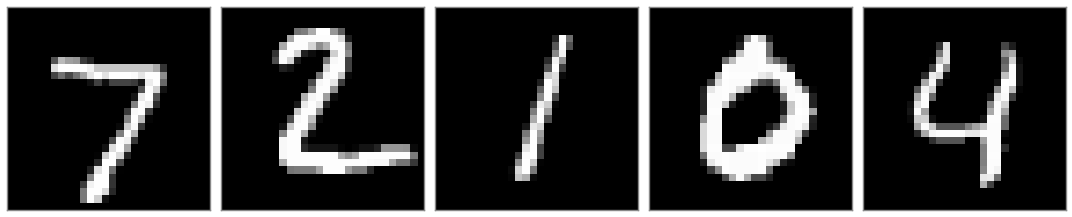

In [5]:
plot_images(data.test.images[:5])

In [6]:
x = tf.placeholder(tf.float32, (None, img_size_flat))

In [7]:
def add_layer(prev_layer, num_neurons, activation='sigmoid'):
    prev_neurons = int(prev_layer.shape[1])
    
    weights = tf.Variable(tf.truncated_normal((prev_neurons, num_neurons), stddev=1e-2))
    biases = tf.Variable(tf.zeros((num_neurons)))
    
    layer = tf.matmul(prev_layer, weights) + biases
    
    if activation == 'tanh':
        layer = tf.nn.tanh(layer)
    elif activation == 'sigmoid':
        layer = tf.nn.sigmoid(layer)
    elif activation == 'relu':
        layer = tf.nn.relu(layer)
        
    return layer

In [8]:
def add_conv_layer(prev_layer, num_filters, pool=False):
    prev_filters = int(prev_layer.shape[3])
    
    weights = tf.Variable(tf.truncated_normal((3, 3, prev_filters, num_filters), stddev=1e-2))
    biases = tf.Variable(tf.zeros((num_filters)))
    
    if pool:
        layer = tf.nn.conv2d(prev_layer, weights, [1, 1, 1, 1], 'SAME')
        layer = tf.nn.max_pool(layer, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    else:
        layer = tf.nn.conv2d(prev_layer, weights, [1, 2, 2, 1], 'VALID')
        
    return tf.nn.relu(layer)

In [9]:
def add_deconv_layer(prev_layer, num_examples, prev_filters, num_filters):
    #prev_filters = int(prev_layer.shape[3])
    #num_examples = int(prev_layer.shape[0])
    output_size = 2 * int(prev_layer.shape[2])
    
    weights = tf.Variable(tf.truncated_normal((3, 3, num_filters, prev_filters), stddev=1e-2))
    biases = tf.Variable(tf.zeros((num_filters)))
    
    layer = tf.nn.conv2d_transpose(prev_layer, weights, [num_examples, output_size, output_size, num_filters], [1, 2, 2, 1])
        
    return tf.nn.relu(layer)

In [10]:
def encoder(x, filter_vectors, neuron_vectors):
    x_image = tf.reshape(x, (-1, img_size, img_size, num_channels))
    
    prev_layer = x_image
    for num_filters in filter_vectors:
        layer = add_conv_layer(prev_layer, num_filters)
        prev_layer = layer
    
    prev_layer = tf.reshape(prev_layer, (-1, int(np.prod(prev_layer.get_shape()[1:]))))
    
    for neurons in neuron_vectors:
        layer = add_layer(prev_layer, neurons, 'relu')
        prev_layer = layer
    return prev_layer

In [11]:
def decoder(x, filter_vectors, neuron_vectors):
    prev_layer = x
    for neurons in neuron_vectors:
        layer = add_layer(prev_layer, neurons, 'None')
        prev_layer = layer
    
    prev_layer = tf.reshape(prev_layer, (-1, 7, 7, 32))
    for num_filters in filter_vectors:
        layer = add_deconv_layer(prev_layer, batch_size, int(prev_layer.shape[3]), num_filters)
        prev_layer = layer
        
    prev_layer = tf.reshape(prev_layer, (-1, img_size_flat))
        
    return prev_layer

In [12]:
true_label = tf.placeholder(tf.float32, (None, num_classes))

In [15]:
encoder_net = encoder(x, [16, 32], [256])
z_mean = add_layer(encoder_net, 32, 'None')
z_std = add_layer(encoder_net, 32, 'None')
noise = tf.placeholder(tf.float32, (None, 32))
z = noise * z_std + z_mean
#decoder_net = decoder(tf.concat([z, true_label], axis=1), [32, 1], [7 * 7 * 32])
decoder_net = decoder(z, [32, 1], [7 * 7 * 32])
(z, decoder_net)

(<tf.Tensor 'add_8:0' shape=(?, 32) dtype=float32>,
 <tf.Tensor 'Reshape_6:0' shape=(256, 784) dtype=float32>)

In [16]:
y_pred = decoder_net
y_true = x

In [17]:
cost = tf.reduce_mean((y_true - y_pred)**2)
latent_cost = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_std) - tf.log(tf.square(z_std)) - 1,1)

In [18]:
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost + 1e-3*latent_cost)

In [21]:
session = tf.Session()

In [22]:
session.run(tf.global_variables_initializer())

In [14]:
batch_size = 256
display_step = 1

In [23]:
def plot_reconstructions():
    image_idx = np.random.randint(0, data.test.num_examples, batch_size)
    
    test_images = data.test.images[image_idx]
        
    reconstructed_images = session.run(y_pred, feed_dict={x: test_images, true_label:data.test.labels[image_idx], noise: np.random.randn(batch_size, 32)})
    
    plot_images(test_images[:5], reconstructed_images[:5])

In [24]:
total_batches = int(data.train.num_examples / batch_size)

def optimize(num_epochs=1):
    plot_reconstructions()
    
    start_time = time()
    
    for epoch in range(num_epochs):
        for i in range(total_batches):
            x_batch, y_batch = data.train.next_batch(batch_size)
            _, loss = session.run((optimizer, cost), feed_dict={x: x_batch, true_label:y_batch, noise: np.random.randn(batch_size, 32)})

        if epoch % display_step == 0:
            plot_reconstructions()
            print("Epoch: {} - cost = {}".format(epoch+1, loss))
        
    print("Optimization finished!")
    print("It took: {}s".format(time() - start_time))

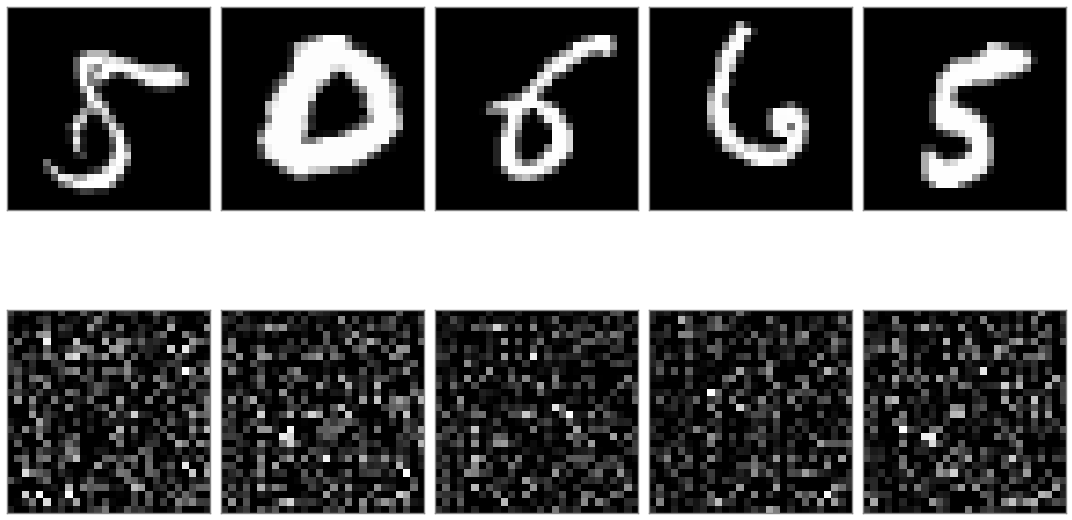

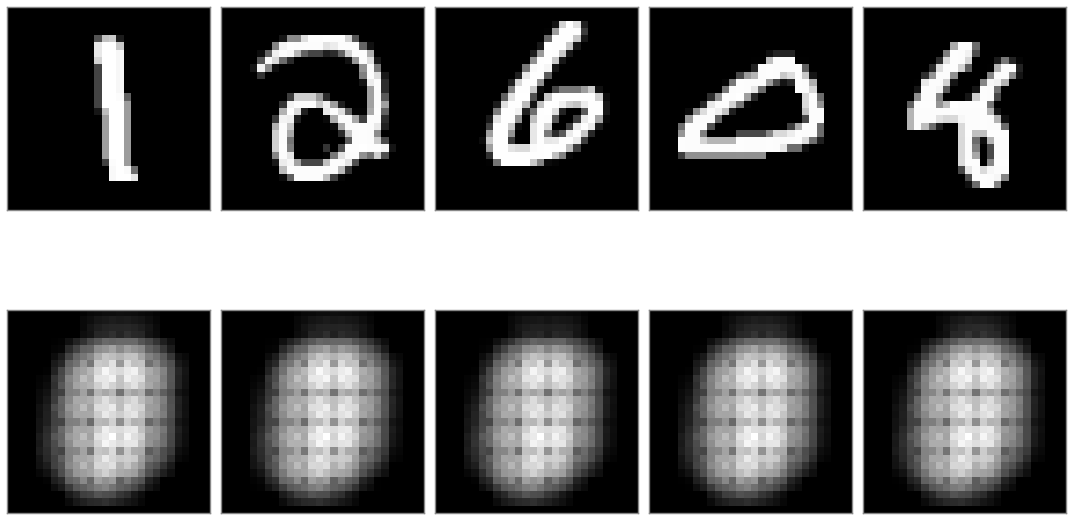

Epoch: 1 - cost = 0.06719981133937836


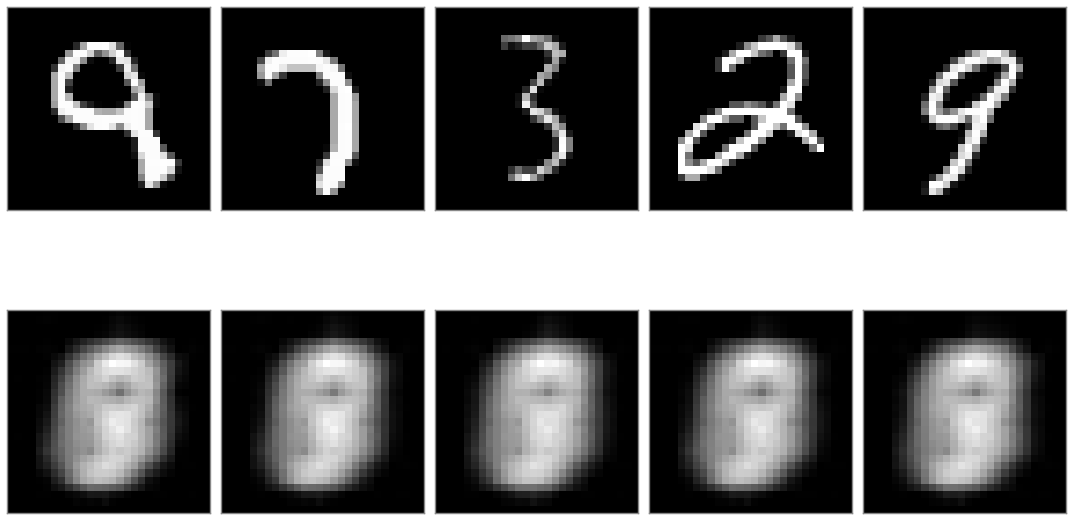

Epoch: 2 - cost = 0.06481236219406128


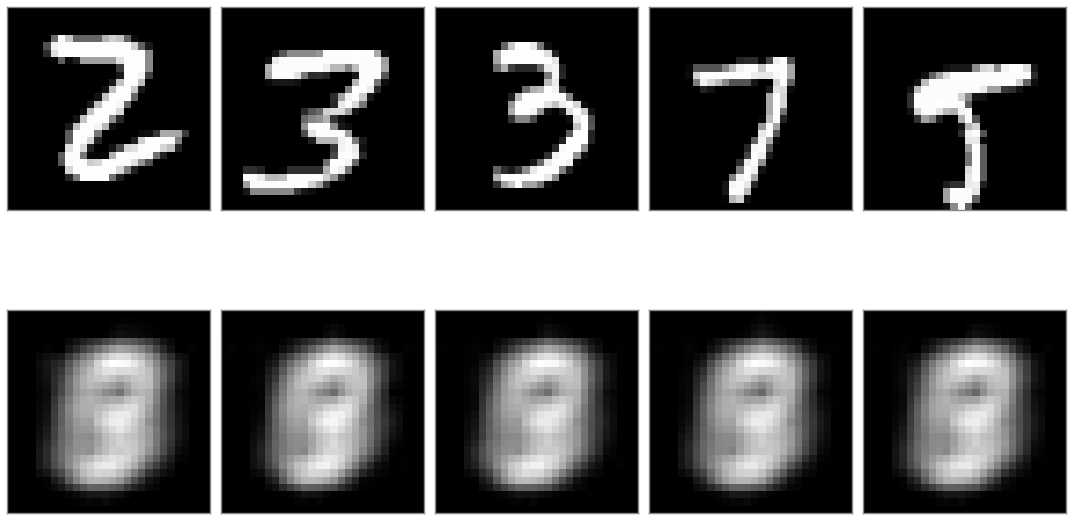

Epoch: 3 - cost = 0.06812385469675064


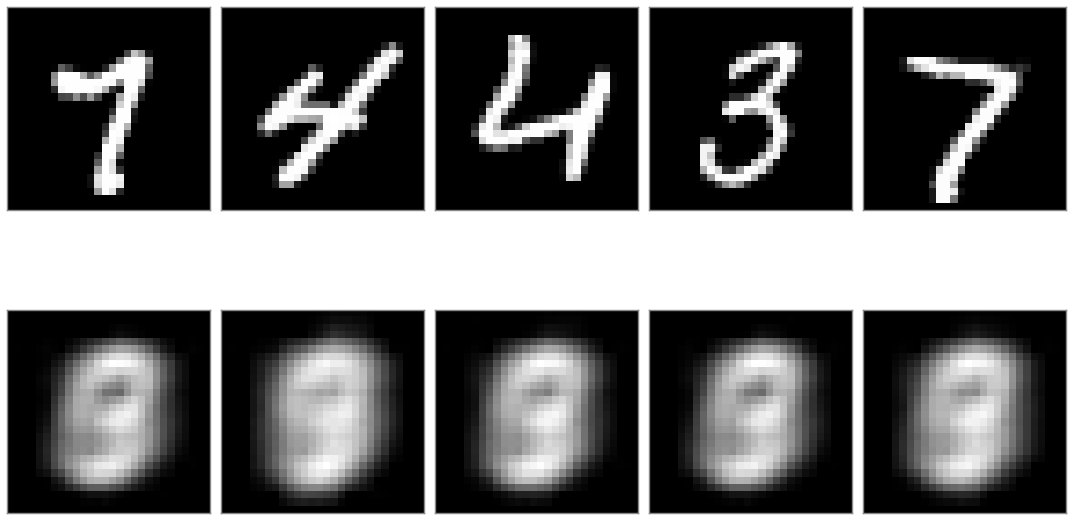

Epoch: 4 - cost = 0.0699576810002327


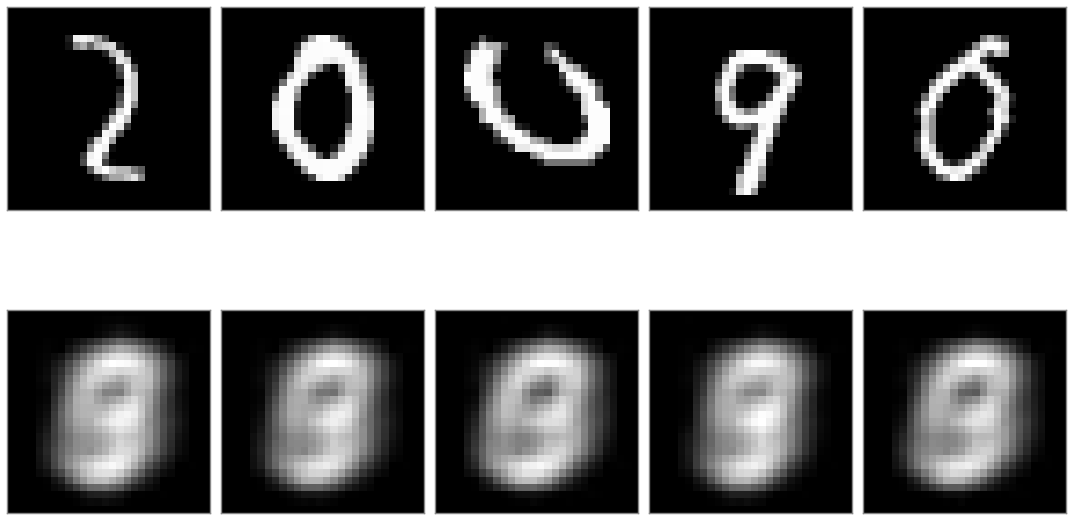

Epoch: 5 - cost = 0.06479816883802414


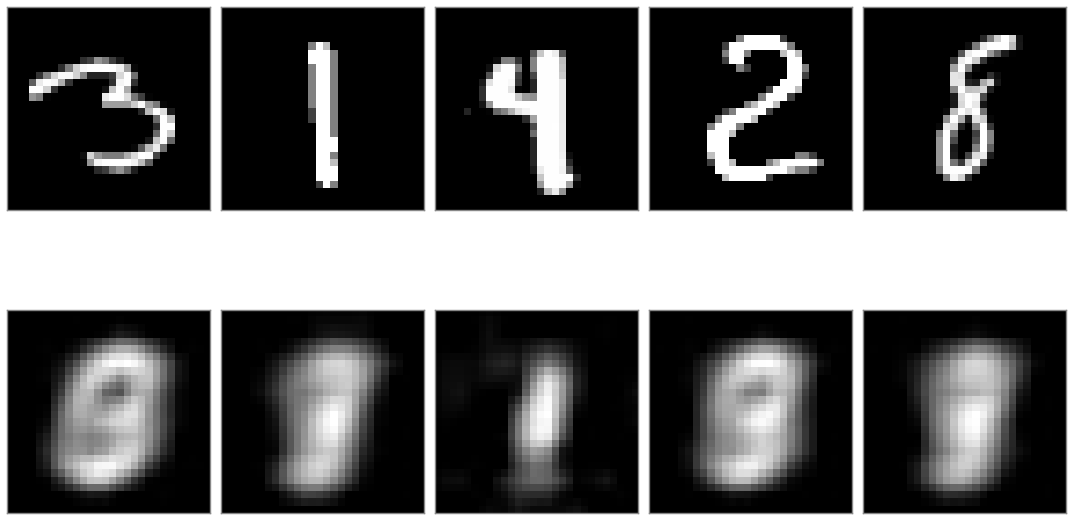

Epoch: 6 - cost = 0.06152981519699097


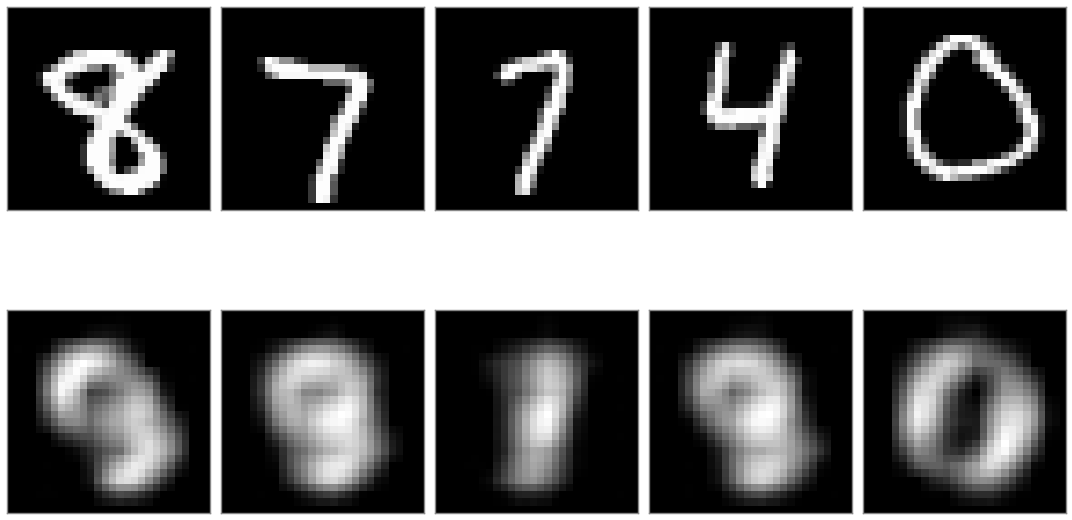

Epoch: 7 - cost = 0.05885733291506767


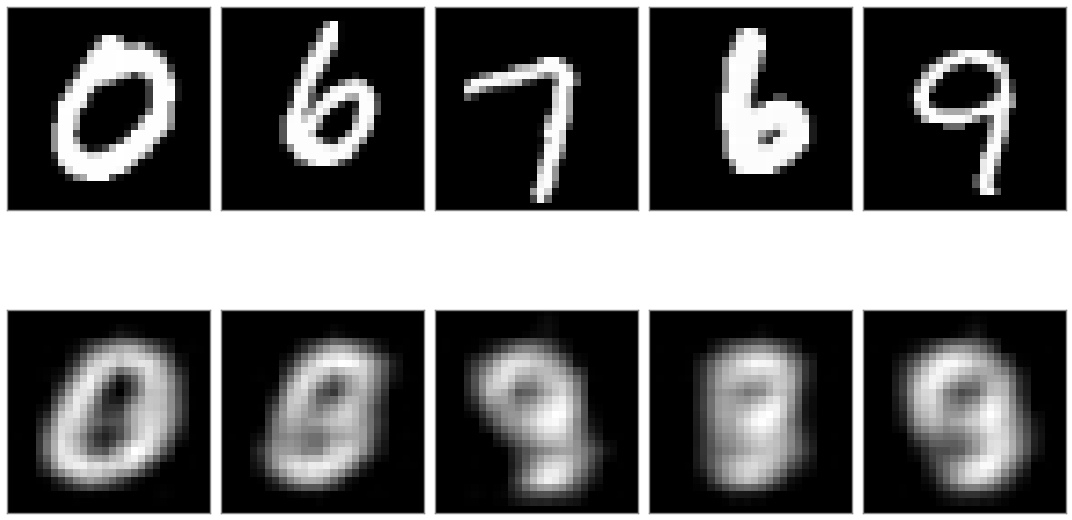

Epoch: 8 - cost = 0.057077910751104355


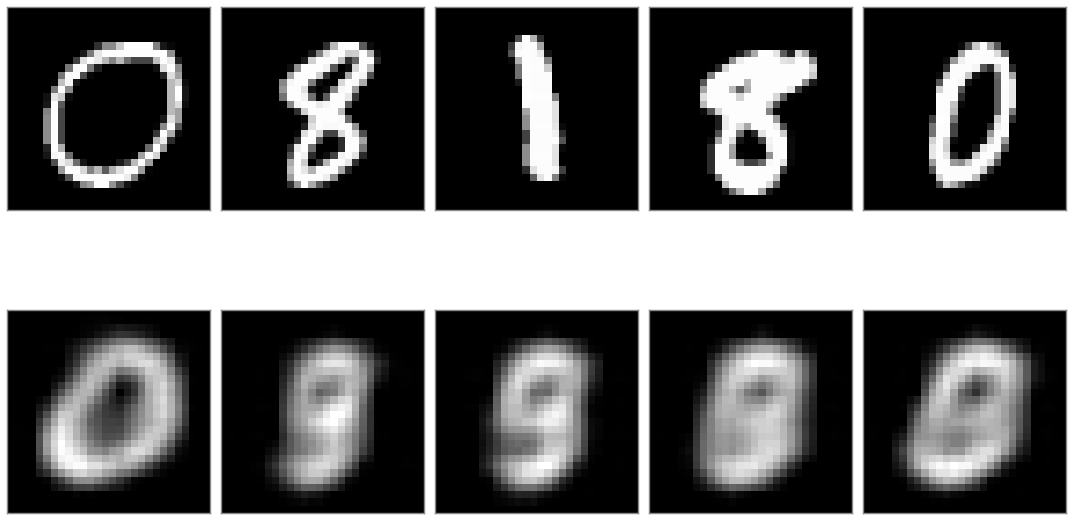

Epoch: 9 - cost = 0.05698008090257645


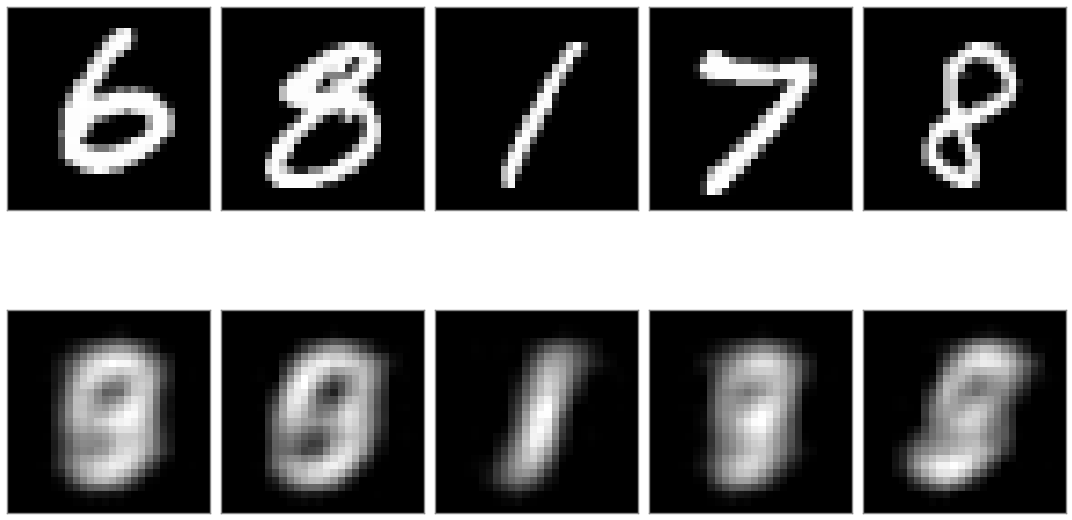

Epoch: 10 - cost = 0.0555197112262249


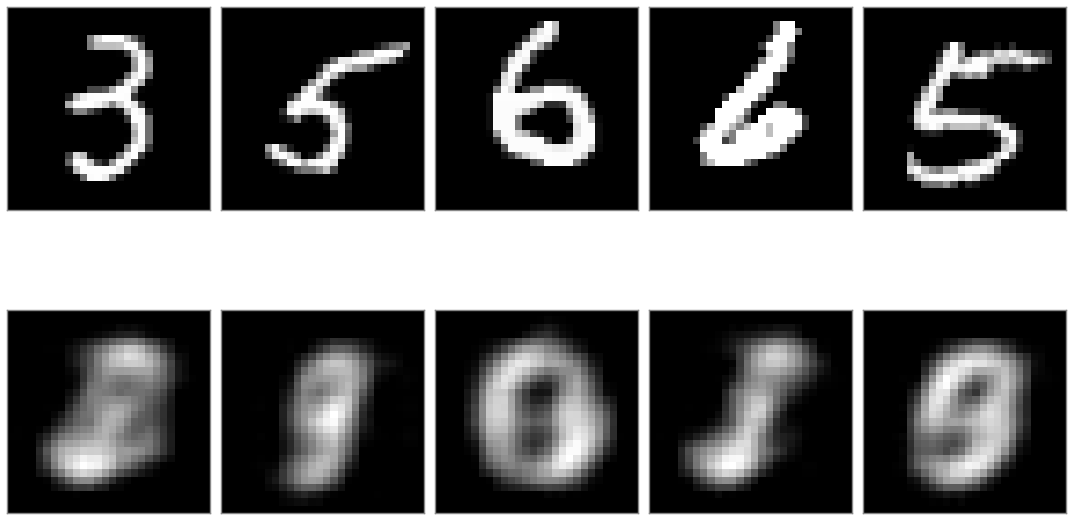

Epoch: 11 - cost = 0.051434990018606186


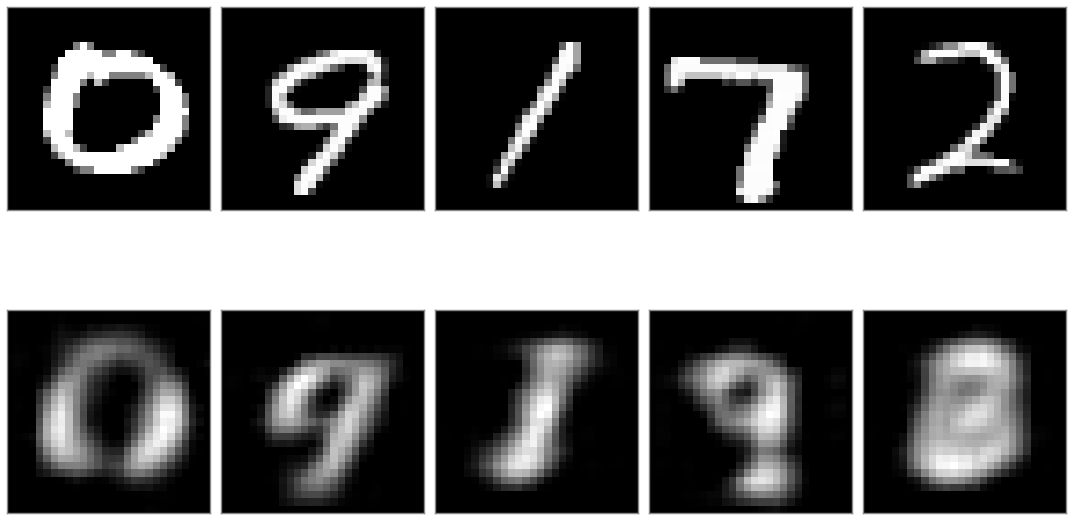

Epoch: 12 - cost = 0.050464387983083725


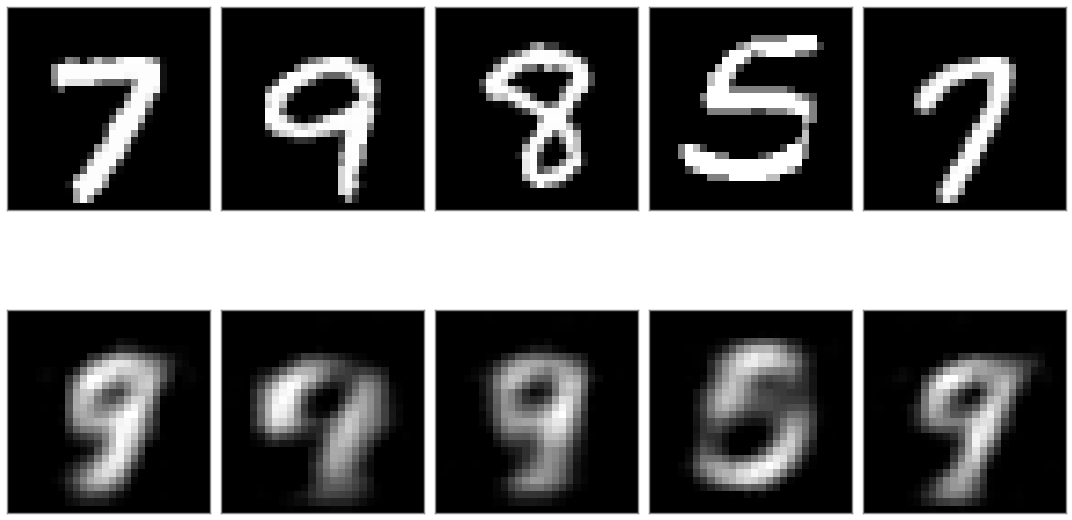

Epoch: 13 - cost = 0.04972520098090172


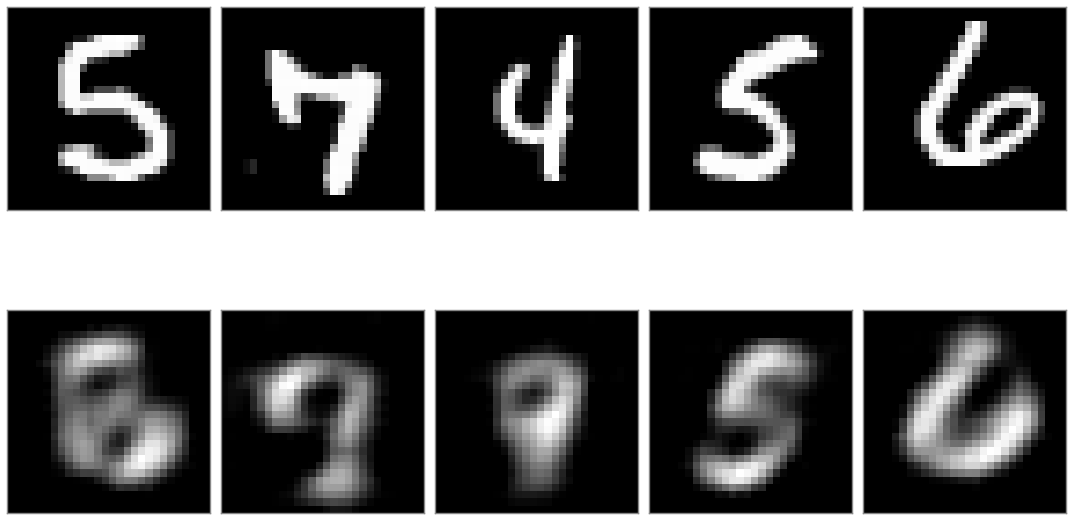

Epoch: 14 - cost = 0.046134188771247864


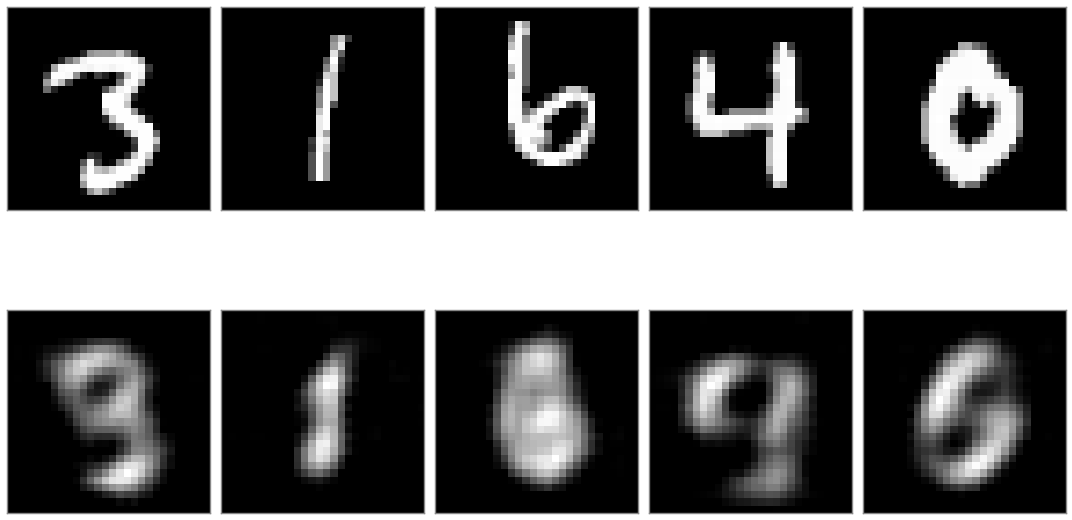

Epoch: 15 - cost = 0.04419252648949623


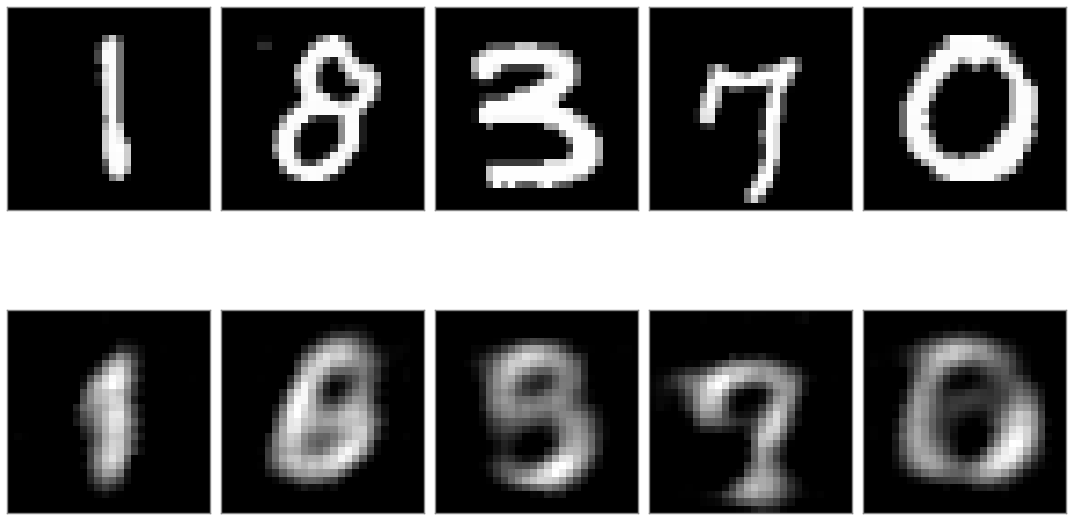

Epoch: 16 - cost = 0.04317700117826462


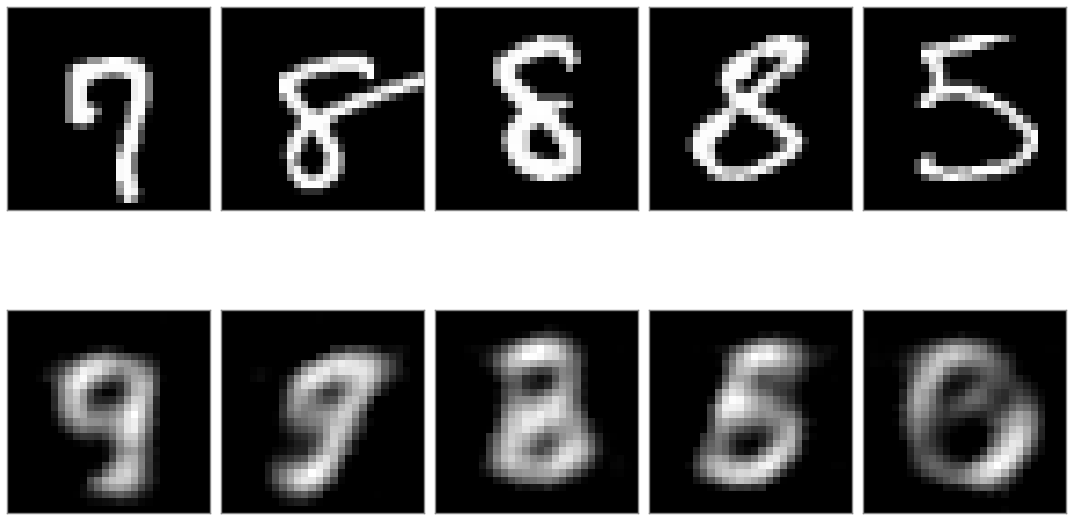

Epoch: 17 - cost = 0.04303579404950142


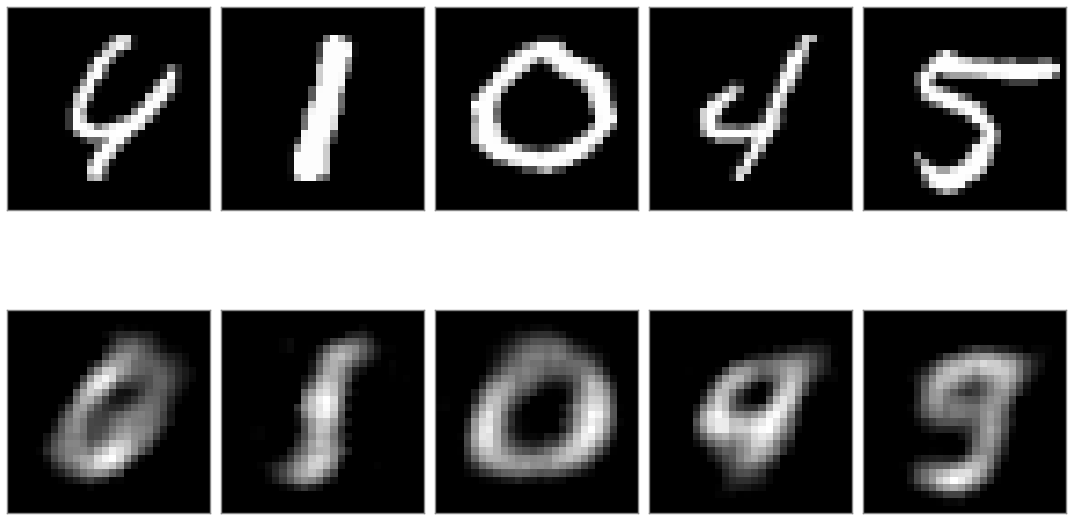

Epoch: 18 - cost = 0.04271025210618973


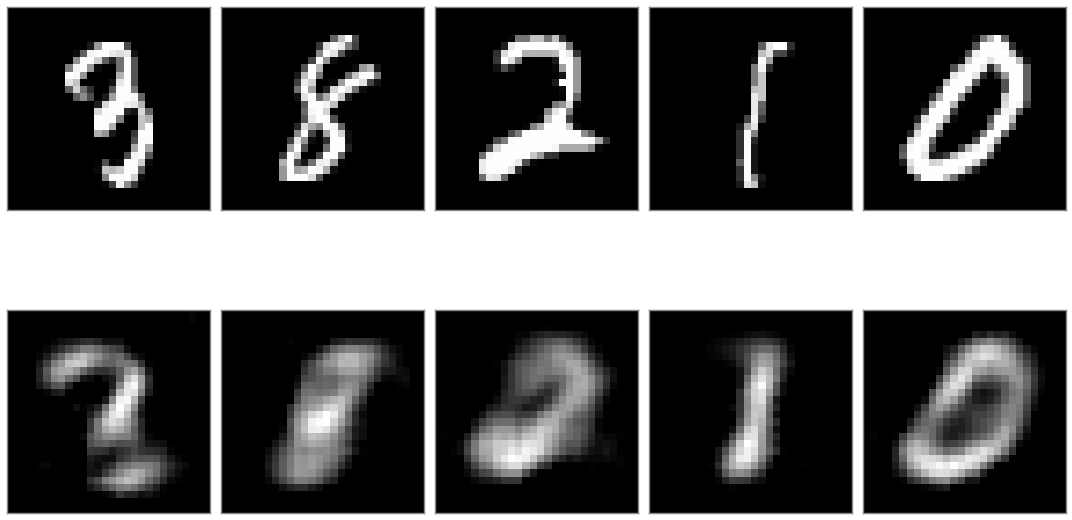

Epoch: 19 - cost = 0.040481336414813995


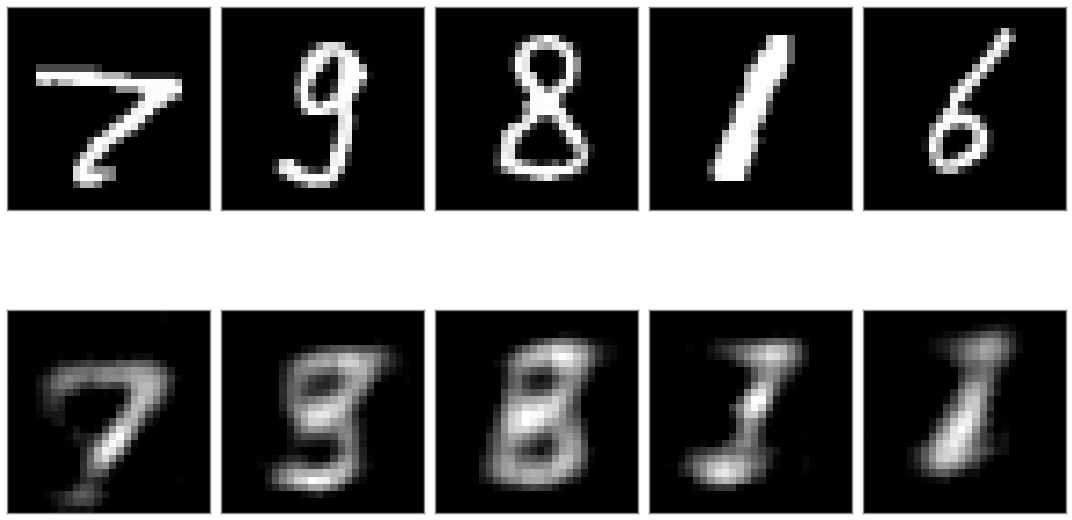

Epoch: 20 - cost = 0.04136223345994949


KeyboardInterrupt: 

In [25]:
optimize(300)

In [ ]:
import utils
rand_vectors = np.random.randn(256, 32)
rand_images = session.run(y_pred, feed_dict={z: rand_vectors})
#and_images[rand_images >= 0.5] = 1
#rand_images[rand_images < 0.5] = 0
for i in range(0, 256, 17):
    utils.plot_images(rand_images[i:i+17])

In [ ]:
rand_vectors = np.random.randn(256, 32)
#rand_labels = np.zeros((5, 10))
#rand_labels[range(5), np.random.randint(0, 10, 5)] = 1
rand_labels = data.validation.labels[np.random.randint(0, data.validation.num_examples, 256)]
rand_cls = np.argmax(rand_labels, axis=1)
rand_images = session.run(y_pred, feed_dict={z: rand_vectors, true_label: rand_labels})
#and_images[rand_images >= 0.5] = 1
#rand_images[rand_images < 0.5] = 0
for i in range(10):
    idx = np.where(rand_cls == i)[0]
    idx_len = len(idx)
    for i in range(int(idx_len / 5)):
        plot_images(rand_images[idx[i:i+5]])

In [30]:
session.close()